
<a id='sp'></a>
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# SciPy


<a id='index-1'></a>

## Contents

- [SciPy](#SciPy)  
  - [Overview](#Overview)  
  - [SciPy versus NumPy](#SciPy-versus-NumPy)  
  - [Statistics](#Statistics)  
  - [Roots and Fixed Points](#Roots-and-Fixed-Points)  
  - [Optimization](#Optimization)  
  - [Integration](#Integration)  
  - [Linear Algebra](#Linear-Algebra)  
  - [Exercises](#Exercises)  
  - [Solutions](#Solutions)  

## Overview

[SciPy](http://www.scipy.org) builds on top of NumPy to provide common tools for scientific programming such as

- [linear algebra](http://docs.scipy.org/doc/scipy/reference/linalg.html)  
- [numerical integration](http://docs.scipy.org/doc/scipy/reference/integrate.html)  
- [interpolation](http://docs.scipy.org/doc/scipy/reference/interpolate.html)  
- [optimization](http://docs.scipy.org/doc/scipy/reference/optimize.html)  
- [distributions and random number generation](http://docs.scipy.org/doc/scipy/reference/stats.html)  
- [signal processing](http://docs.scipy.org/doc/scipy/reference/signal.html)  
- etc., etc  


Like NumPy, SciPy is stable, mature and widely used.

Many SciPy routines are thin wrappers around industry-standard Fortran libraries such as LAPACK, BLAS, etc.

It’s not really necessary to “learn” SciPy as a whole.

A more common approach is to get some idea of what’s in the library and then look up [documentation](http://docs.scipy.org/doc/scipy/reference/index.html) as required.

In this lecture, we aim only to highlight some useful parts of the package.

## SciPy versus NumPy

SciPy is a package that contains various tools that are built on top of NumPy, using its array data type and related functionality.

In fact, when we import SciPy we also get NumPy, as can be seen from this excerpt the SciPy initialization file:

In [ ]:
# Import numpy symbols to scipy namespace
from numpy import *
from numpy.random import rand, randn
from numpy.fft import fft, ifft
from numpy.lib.scimath import *

However, it’s more common and better practice to use NumPy functionality explicitly

In [ ]:
import numpy as np

a = np.identity(3)

What is useful in SciPy is the functionality in its sub-packages

- `scipy.optimize`, `scipy.integrate`, `scipy.stats`, etc.  


Let’s explore some of the major sub-packages.

## Statistics


<a id='index-4'></a>
The `scipy.stats` subpackage supplies

- numerous random variable objects (densities, cumulative distributions, random sampling, etc.)  
- some estimation procedures  
- some statistical tests  

### Random Variables and Distributions

Recall that `numpy.random` provides functions for generating random variables

In [ ]:
np.random.beta(5, 5, size=3)

This generates a draw from the distribution below when `a, b = 5, 5`


<a id='equation-betadist2'></a>
$$
f(x; a, b) = \frac{x^{(a - 1)} (1 - x)^{(b - 1)}}
    {\int_0^1 u^{(a - 1)} (1 - u)^{(b - 1)} du}
    \qquad (0 \leq x \leq 1) \tag{1}
$$

Sometimes we need access to the density itself, or the cdf, the quantiles, etc.

For this, we can use `scipy.stats`, which provides all of this functionality as well as random number generation in a single consistent interface.

Here’s an example of usage

In [ ]:
from scipy.stats import beta
import matplotlib.pyplot as plt
%matplotlib inline

q = beta(5, 5)      # Beta(a, b), with a = b = 5
obs = q.rvs(2000)   # 2000 observations
grid = np.linspace(0.01, 0.99, 100)

fig, ax = plt.subplots()
ax.hist(obs, bins=40, density=True)
ax.plot(grid, q.pdf(grid), 'k-', linewidth=2)
plt.show()

The object `q` that represents the distribution has additional useful methods, including

In [ ]:
q.cdf(0.4)      # Cumulative distribution function

In [ ]:
q.ppf(0.8)      # Quantile (inverse cdf) function

In [ ]:
q.mean()

The general syntax for creating these objects that represent distributions (of type `rv_frozen`) is

> `name = scipy.stats.distribution_name(shape_parameters, loc=c, scale=d)`


Here `distribution_name` is one of the distribution names in [scipy.stats](http://docs.scipy.org/doc/scipy/reference/stats.html).

The `loc` and `scale` parameters transform the original random variable
$ X $ into $ Y = c + d X $.

### Alternative Syntax

There is an alternative way of calling the methods described above.

For example, the code that generates the figure above can be replaced by

In [ ]:
obs = beta.rvs(5, 5, size=2000)
grid = np.linspace(0.01, 0.99, 100)

fig, ax = plt.subplots()
ax.hist(obs, bins=40, density=True)
ax.plot(grid, beta.pdf(grid, 5, 5), 'k-', linewidth=2)
plt.show()

### Other Goodies in scipy.stats

There are a variety statistical functions in `scipy.stats`.

For example, `scipy.stats.linregress` implements simple linear regression

In [ ]:
from scipy.stats import linregress

x = np.random.randn(200)
y = 2 * x + 0.1 * np.random.randn(200)
gradient, intercept, r_value, p_value, std_err = linregress(x, y)
gradient, intercept

To see the full list, consult the [documentation](https://docs.scipy.org/doc/scipy/reference/stats.html#statistical-functions-scipy-stats).

## Roots and Fixed Points

A **root** or **zero** of a real function $ f $ on $ [a,b] $ is an $ x \in [a, b] $ such that $ f(x)=0 $.

For example, if we plot the function


<a id='equation-root-f'></a>
$$
f(x) = \sin(4 (x - 1/4)) + x + x^{20} - 1 \tag{2}
$$

with $ x \in [0,1] $ we get

In [ ]:
f = lambda x: np.sin(4 * (x - 1/4)) + x + x**20 - 1
x = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
ax.plot(x, f(x))
ax.axhline(ls='--', c='k')
plt.show()

The unique root is approximately 0.408.

Let’s consider some numerical techniques for finding roots.

### Bisection


<a id='index-6'></a>
One of the most common algorithms for numerical root-finding is *bisection*.

To understand the idea, recall the well-known game where

- Player A thinks of a secret number between 1 and 100  
- Player B asks if it’s less than 50  
  
  - If yes, B asks if it’s less than 25  
  - If no, B asks if it’s less than 75  
  


And so on.

This is bisection.

Here’s a simplistic implementation of the algorithm in Python.

It works for all sufficiently well behaved increasing continuous functions with $ f(a) < 0 < f(b) $


<a id='bisect-func'></a>

In [ ]:
def bisect(f, a, b, tol=10e-5):
    """
    Implements the bisection root finding algorithm, assuming that f is a
    real-valued function on [a, b] satisfying f(a) < 0 < f(b).
    """
    lower, upper = a, b

    while upper - lower > tol:
        middle = 0.5 * (upper + lower)
        if f(middle) > 0:   # root is between lower and middle
            lower, upper = lower, middle
        else:               # root is between middle and upper
            lower, upper = middle, upper

    return 0.5 * (upper + lower)

Let’s test it using the function $ f $ defined in [(2)](#equation-root-f)

In [ ]:
bisect(f, 0, 1)

Not surprisingly, SciPy provides its own bisection function.

Let’s test it using the same function $ f $ defined in [(2)](#equation-root-f)

In [ ]:
from scipy.optimize import bisect

bisect(f, 0, 1)

### The Newton-Raphson Method


<a id='index-8'></a>
Another very common root-finding algorithm is the [Newton-Raphson method](https://en.wikipedia.org/wiki/Newton%27s_method).

In SciPy this algorithm is implemented by `scipy.optimize.newton`.

Unlike bisection, the Newton-Raphson method uses local slope information in an attempt to increase the speed of convergence.

Let’s investigate this using the same function $ f $ defined above.

With a suitable initial condition for the search we get convergence:

In [ ]:
from scipy.optimize import newton

newton(f, 0.2)   # Start the search at initial condition x = 0.2

But other initial conditions lead to failure of convergence:

In [ ]:
newton(f, 0.7)   # Start the search at x = 0.7 instead

### Hybrid Methods

A general principle of numerical methods is as follows:

- If you have specific knowledge about a given problem, you might be able to exploit it to generate efficiency.  
- If not, then the choice of algorithm involves a trade-off between speed and robustness.  


In practice, most default algorithms for root-finding, optimization and fixed points use *hybrid* methods.

These methods typically combine a fast method with a robust method in the following manner:

1. Attempt to use a fast method  
1. Check diagnostics  
1. If diagnostics are bad, then switch to a more robust algorithm  


In `scipy.optimize`, the function `brentq` is such a hybrid method and a good default

In [ ]:
from scipy.optimize import brentq

brentq(f, 0, 1)

Here the correct solution is found and the speed is better than bisection:

In [ ]:
%timeit brentq(f, 0, 1)

In [ ]:
%timeit bisect(f, 0, 1)

### Multivariate Root-Finding


<a id='index-9'></a>
Use `scipy.optimize.fsolve`, a wrapper for a hybrid method in MINPACK.

See the [documentation](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html) for details.

### Fixed Points

A **fixed point** of a real function $ f $ on $ [a,b] $ is an $ x \in [a, b] $ such that $ f(x)=x $.


<a id='index-10'></a>
SciPy has a function for finding (scalar) fixed points too

In [ ]:
from scipy.optimize import fixed_point

fixed_point(lambda x: x**2, 10.0)  # 10.0 is an initial guess

If you don’t get good results, you can always switch back to the `brentq` root finder, since
the fixed point of a function $ f $ is the root of $ g(x) := x - f(x) $.

## Optimization


<a id='index-12'></a>
Most numerical packages provide only functions for *minimization*.

Maximization can be performed by recalling that the maximizer of a function $ f $ on domain $ D $ is
the minimizer of $ -f $ on $ D $.

Minimization is closely related to root-finding: For smooth functions, interior optima correspond to roots of the first derivative.

The speed/robustness trade-off described above is present with numerical optimization too.

Unless you have some prior information you can exploit, it’s usually best to use hybrid methods.

For constrained, univariate (i.e., scalar) minimization, a good hybrid option is `fminbound`

In [33]:
from scipy.optimize import fminbound

fminbound(lambda x: x**2, -1, 2)  # Search in [-1, 2]

0.0

### Multivariate Optimization


<a id='index-13'></a>
Multivariate local optimizers include `minimize`, `fmin`, `fmin_powell`, `fmin_cg`, `fmin_bfgs`, and `fmin_ncg`.

Constrained multivariate local optimizers include `fmin_l_bfgs_b`, `fmin_tnc`, `fmin_cobyla`.

See the [documentation](http://docs.scipy.org/doc/scipy/reference/optimize.html) for details.

## Integration


<a id='index-15'></a>
Most numerical integration methods work by computing the integral of an approximating polynomial.

The resulting error depends on how well the polynomial fits the integrand, which in turn depends on how “regular” the integrand is.

In SciPy, the relevant module for numerical integration is `scipy.integrate`.

A good default for univariate integration is `quad`

In [34]:
from scipy.integrate import quad

integral, error = quad(lambda x: x**2, 0, 1)
integral

0.33333333333333337

In fact, `quad` is an interface to a very standard numerical integration routine in the Fortran library QUADPACK.

It uses [Clenshaw-Curtis quadrature](https://en.wikipedia.org/wiki/Clenshaw-Curtis_quadrature),  based on expansion in terms of Chebychev polynomials.

There are other options for univariate integration—a useful one is `fixed_quad`, which is fast and hence works well inside `for` loops.

There are also functions for multivariate integration.

See the [documentation](http://docs.scipy.org/doc/scipy/reference/integrate.html) for more details.

## Linear Algebra


<a id='index-17'></a>
We saw that NumPy provides a module for linear algebra called `linalg`.

SciPy also provides a module for linear algebra with the same name.

The latter is not an exact superset of the former, but overall it has more functionality.

We leave you to investigate the [set of available routines](http://docs.scipy.org/doc/scipy/reference/linalg.html).

## Exercises


<a id='sp-ex1'></a>

### Exercise 1



Consider a firm with profit function 

$$ \pi(p, q) = pq -\exp(q) - 0.5 q^2 $$

Plot profit maximizing $q$ as a function of price for $p \in [5, 10]$.


Note: for this exercise, the solution is embedded in the notebook rather than the website.  See below.

In [ ]:
for i in range(20):
    print("solution below.")

## Solutions

### Exercise 1

Here’s a reasonable solution:

In [35]:
def profit(p, q):
    return p * q - np.exp(q) - 0.5 * q**2


a, b, grid_size = 5, 10, 25
prices = np.linspace(a, b, grid_size)

opt_quantity = np.empty_like(prices)
max_q = 20

for i, p in enumerate(prices):

    def loss(q):
        return - profit(p, q)
    
    opt_quantity[i] = fminbound(loss, 0, max_q)

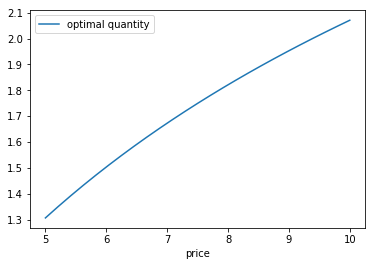

In [36]:
fig, ax = plt.subplots()
ax.plot(prices, opt_quantity, label="optimal quantity")
ax.set_xlabel("price")
ax.legend()
plt.show()

In [45]:
# minimize method

import scipy
from scipy.optimize import minimize
import numpy as np

def profit(q):
    return - q*p + np.exp(q) + 0.5*q**2

In [46]:
prices = np.linspace(5, 10, 100)

q_opt = []

for p in prices:
    res = minimize(profit, 0)
    q_opt.append(res.x)

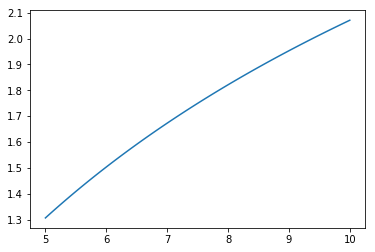

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

prices = np.array(prices)
fig, ax  = plt.subplots()
plt.plot(prices, q_opt)